In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preparing Notebook: Adding directory to path so it's possible to import scripts

In [ ]:
import sys
def GetRoot(user = None):
    '''
    Deterimines what the root path is for google collab.
    Inputs:
    user (str): Name of the person using this notebook.

    Output:
    (str) root path
    '''
    if user.lower() == 'jackie':
        root = '/content/drive/MyDrive/AUTOMATION/DarthImputer(AutomationProject)'
    elif user.lower() == 'thomas':
        root = '/content/drive/MyDrive/Colab Notebooks/DarthImputer(AutomationProject)'
    elif user.lower() == 'gabe':
        root = '/content/drive/MyDrive/DarthImputer(AutomationProject)'
    else:
        raise Exception("Ya fucked up son. Who are you?")
    
    return root

root = GetRoot('gabe')
sys.path.append(f'{root}/src')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import helpers
import basic_impute
import mice

In [7]:
import importlib
importlib.reload(mice)
importlib.reload(helpers)
importlib.reload(basic_impute)

<module 'basic_impute' from '/Users/thomaszhang/Development/Python/02750_Automation_2024/project/src/basic_impute.py'>

# Step 0: Importing the data

In [1]:
import pandas as pd

# Brain
def ReadData(root, dataset = None):
  """
  Input:
    root (str): Path to the root of the project
    dataset (str): Which data set are you using? "brain","lung" or "breast"
  """

  if dataset.lower() == 'brain':
    path = root + '/data/brain/Brain_GSE50161.csv'
  elif dataset.lower() == 'breast':
    path = root + '/data/breast/Breast_GSE45827.csv'
  elif dataset.lower() == 'lung':
    path = root + '/data/lung/clean/complete_dataframe.csv'
  else:
    raise Exception("I don't have that dataset you ding dong.")

  data = pd.read_csv(path)
  return data

In [3]:
root = '..'
brain_df = ReadData(root, 'brain')
data = brain_df.iloc[:, 2:].to_numpy() # Numpy arr of the features

In [10]:
proportion = 33000/brain_df.shape[1]
highest_var_features = helpers.HighestVarianceFeatures(data, proportion)
proportion = 60/brain_df.shape[1]
highest_var_features_pca = helpers.HighestVarianceDecomposition(data, proportion)

Percentage of explained variance is: 0.8973539468565515
Percentage of explained variance is: 0.8997280898784604


# 1. Random masking to generate missing data

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

In [ ]:
matrix = brain_df.iloc[:, 2:].to_numpy()

all_labels = helpers.EncodeLabels(brain_df['type'].to_numpy())
masked_data = helpers.Implement_Random_Masking(matrix, 0.3, 5000, 2024)


(130, 54675)


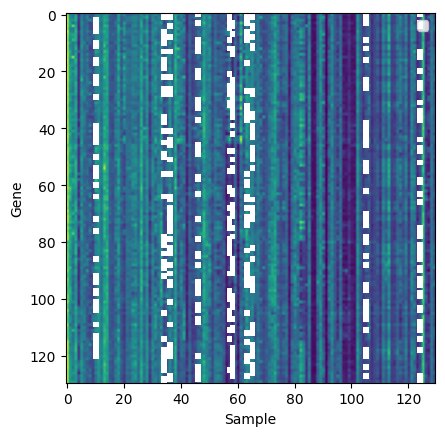

In [ ]:
print(masked_data.shape)

plt.imshow(masked_data[:,:130])

plt.xlabel("Sample")

plt.ylabel("Gene")
plt.legend(["Expression"])

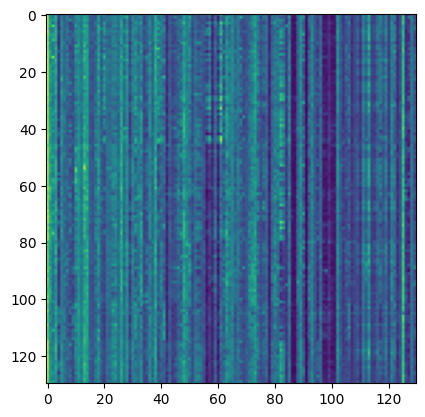

In [ ]:
plt.imshow(matrix[:, :130])

In [ ]:
mice_res = mice.ImputeDataMice(masked_data[:, :130], seed=2024)

Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 571.30it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 805.73it/s]

In [ ]:
np.sum((mice_res - matrix[:, :130])**2)

236.7408005172028

In [ ]:
def MSE(y, pred):

  return np.sum((y - pred)**2)


class FeatureImputationPipeline():

  def get_params(self, parameters_config):

    """
    Require: num_rows : the proportion of rows to mask
             num_cols : the number of rows to mask

    can have different imputation parameters depending on the method.

    Input : paramters config : A dictionary mapping each parameter
                               to a value.

    Output : dump the values in parameters config into self.params

    """

    self.params = {}

    for k in parameters_config:
        self.params[k] = parameters_config[k]




    return

  def __init__(self, method, parameters_config, data, loss_func = MSE):
    self.method = method
    self.get_params(parameters_config)
    self.features = data["features"]
    self.labels = data["labels"]
    self.loss = loss_func

    return

  def mask_data(self, seed):

    """
    Masks data randomly given proportion of rows and columns.

    """


    self.masked_data = helpers.Implement_Random_Masking(self.features,
                                                   self.params["num_rows"],
                                                   self.params["num_cols"],
                                                   seed)
    return

  def run_simulation(self, seed):

    """
    Given a seed, run a masking and imputing loop.
    Compute the loss given a specific loss function.

    """

    self.mask_data(seed)
    res = self.method(self.masked_data, seed)
    loss = self.loss(res, self.features)

    return loss

  def run_multiple_seeds(self, num_simuls):

    """
    Averages results of simulation across multiple
    seeds. Runs num_simuls times and returns mean loss.

    """

    losses = []
    for i in range(num_simuls):
      loss = self.run_simulation(i)
      losses.append(loss)

    return np.mean(losses)

  def run_multiple_params(self, num_simuls, variables):

    """
    Run multiple seeds for different parameter values.
    For example, can test the performance of imputation
    method as the proportion of rows increase.

    """

    for k in variables:
      name = k
      grid = variables[k]

    x_axis = []
    mean_loss = []

    for i in grid:
      self.params[name] = i
      mean_loss.append(self.run_multiple_seeds(num_simuls))
      x_axis.append(i)

    return x_axis, mean_loss



In [ ]:
data = {"features" : matrix[:, :130], "labels" : all_labels}

parameters_config = {"num_rows" : 0.3, "num_cols" : 75}


pipeline = FeatureImputationPipeline(
    method = mice.ImputeDataMice,
    parameters_config = parameters_config,
    data = data,
    loss_func = MSE
)

var = {"num_cols" : [10, 35, 75, 95, 105, 115]}

res = pipeline.run_multiple_params(num_simuls = 1, variables = var)



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 405.79it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 968.62it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 231.14it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 259.88it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 163.38it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 148.44it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 147.33it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 178.00it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 161.95it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 165.21it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 144.35it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 145.85it/s]

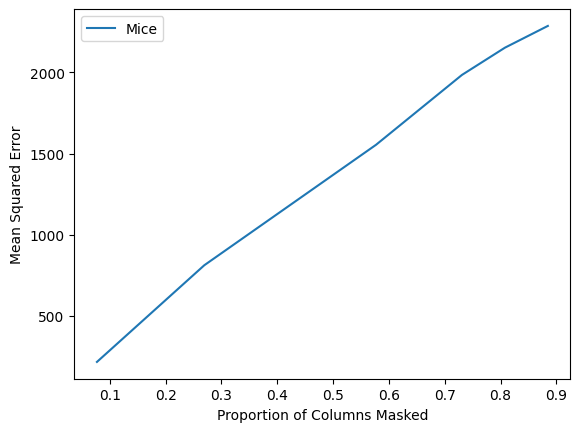

In [ ]:
plt.plot(np.array(res[0]) / 130, res[1])


plt.ylabel("Mean Squared Error")

plt.xlabel("Proportion of Columns Masked")
plt.legend(["Mice"])

In [ ]:
data = {"features" : matrix[:, :130], "labels" : all_labels}

parameters_config = {"num_rows" : 0.3, "num_cols" : 60}


pipeline = FeatureImputationPipeline(
    method = mice.ImputeDataMice,
    parameters_config = parameters_config,
    data = data,
    loss_func = MSE
)

var = {"num_rows" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

results = []
for i in [10, 20, 30, 40, 50]:
  pipeline.params["num_cols"] = i
  res = pipeline.run_multiple_params(num_simuls = 1, variables = var)
  results.append(res)



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 967.99it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 884.84it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 1092.23it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 788.74it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 624.70it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 641.19it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 548.70it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 788.29it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 700.60it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 769.08it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 769.98it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 766.06it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 868.53it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 880.49it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 1722.00it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 1321.16it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 1730.85it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 2571.66it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 350.01it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 368.03it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 390.76it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 382.88it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 417.53it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 309.38it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 487.27it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 510.43it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 803.17it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 804.24it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 853.63it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 837.49it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 865.57it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 917.46it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 1203.12it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 960.11it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 2732.02it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 2901.27it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 611.82it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 817.26it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 791.23it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 436.28it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 404.72it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 459.31it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 527.48it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 500.19it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 391.70it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 362.56it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 427.72it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 442.71it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 507.05it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 456.51it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 725.90it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 640.89it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 1031.49it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 1321.71it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 239.44it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 276.07it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 717.91it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 642.21it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 813.91it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 761.72it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 881.55it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 803.75it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 928.41it/s] 



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 773.56it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 415.29it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 725.87it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 1007.12it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 1391.05it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 703.14it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 953.89it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 1035.17it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 1324.19it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 233.34it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 239.33it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 258.95it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 237.65it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 291.68it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 285.28it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 296.14it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 273.56it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 345.79it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 265.26it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 714.79it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 464.43it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 489.33it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 520.32it/s]



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 787.87it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 966.12it/s] 



Iteration: 0


100%|██████████| 130/130 [00:00<00:00, 1259.57it/s]



Iteration: 1


100%|██████████| 130/130 [00:00<00:00, 1382.02it/s]

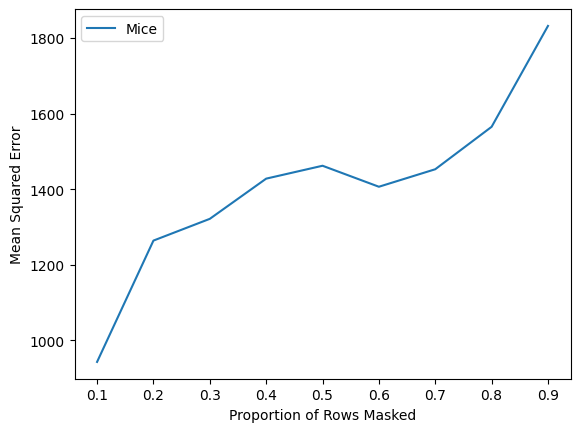

In [ ]:
plt.plot(np.array(res[0]), res[1])


plt.ylabel("Mean Squared Error")

plt.xlabel("Proportion of Rows Masked")
plt.legend(["Mice"])

In [ ]:
plt.plot(results[0])

In [ ]:
# def Implement_Random_Masking(data, masking_portion):
#   '''
#   This function takes X and the masking portion and return the new X with the same shape with missing the given portion of random data
#   Args:
#   - data: full data
#   - Masking portion: float
#   Returns:
#   - masked_data: same shape as given data, missing given portion of data
#   '''
#   mask_indices = np.random.rand(*data.shape) < masking_portion
#   masked_data = data.copy()
#   masked_data[mask_indices] = np.nan

#   return masked_data

In [ ]:
brain_X = brain_df.drop(['samples', 'type'], axis=1).to_numpy()
brain_Y_original = brain_df['type'].to_numpy()

In [ ]:
encoder = LabelEncoder()
encoder.fit(all_labels)
brain_Y_encoded = encoder.transform(brain_Y_original)

In [ ]:
brain_X.shape, brain_Y_encoded.shape

((130, 54675), (130,))

In [ ]:
brain_X_train, brain_X_test, brain_Y_train, brain_Y_test = train_test_split(brain_X, brain_Y_encoded, test_size=0.2, random_state=42)

# Base learner

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import mode

# 1. Full dataset

In [ ]:
rf_clf0 = RandomForestClassifier(n_estimators=10, random_state=42)

In [ ]:
rf_clf0.fit(brain_X_train, brain_Y_train)

RandomForestClassifier(n_estimators=10, random_state=42)

In [ ]:
pred_0 = rf_clf0.predict(brain_X_test)

In [ ]:
score_0 = accuracy_score(pred_0, brain_Y_test)

In [ ]:
score_0

0.8846153846153846

# 2. 10% masking

In [ ]:
np.random.seed(42)

In [ ]:
X_train_1 = Implement_Random_Masking(brain_X_train, 0.1)

## 2.1. Mean Imputation

In [ ]:
def Imputation_Mean(X):
  '''
  Implement imputation
  '''
  X_imputed = X.copy()
  for col in np.arange(X_imputed.shape[1]):
    col_mean = np.nanmean(X_imputed[:, col])
    X_imputed[np.isnan(X_imputed[:, col]), col] = col_mean
  return X_imputed

In [ ]:
X_imputed_1 = Imputation_Mean(X_train_1)

### 2.1.2. Error compared to the original dataset

In [ ]:
diff1 = mean_squared_error(X_imputed_1, brain_X_train)
diff1

0.050901821703508106

### 2.1.3. Accuracy on test data

In [ ]:
rf_clf1 = RandomForestClassifier(n_estimators=10, random_state=42)
rf_clf1.fit(X_imputed_1, brain_Y_train)
pred_1 = rf_clf1.predict(brain_X_test)
score_1 = accuracy_score(pred_1, brain_Y_test)
score_1

0.8846153846153846

## 2.2. Mode Imputation

In [ ]:
def Imputation_Mode(X):
  '''
  Implement imputation
  '''
  X_imputed = X.copy()
  for col in np.arange(X_imputed.shape[1]):
    unique_values, counts = np.unique(X_imputed[:,col], return_counts=True)
    reverse_sorted_counts = np.argsort(counts)[::-1]
    col_mode = unique_values[0] if unique_values[0] != np.nan else unique_values[1]
    X_imputed[np.isnan(X_imputed[:, col]), col] = col_mode
  return X_imputed

In [ ]:
unique_values, counts = np.unique([np.nan, np.nan, 1,2,3,2,2], return_counts=True)
unique_values, counts

(array([ 1.,  2.,  3., nan]), array([1, 3, 1, 2]))

In [ ]:
np.argsort(counts)[::-1]

array([1, 3, 2, 0])

In [ ]:
X_imputed_mode1 = Imputation_Mode(X_train_1)

### 2.2.2. Error compared to the original dataset

In [ ]:
diff_mode1 = mean_squared_error(X_imputed_mode1, brain_X_train)
diff_mode1

0.2838962411981033

### 2.2.3. Accuracy on test data

In [ ]:
rf_clf1 = RandomForestClassifier(n_estimators=10, random_state=42)
rf_clf1.fit(X_imputed_mode1, brain_Y_train)
pred_mode_1 = rf_clf1.predict(brain_X_test)
score_mode_1 = accuracy_score(pred_1, brain_Y_test)
score_mode_1

0.8846153846153846

In [ ]:
int(3/2)

1